In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram


### Task 1: <br />
* given an input list with N = 2^n numbers of bitsize m <br />
* return superpositions of the numbers that have alternating  bitstring. <br />
* It is guaranteed there will be M = 2 numbers with alternating bitstrings. <br />


In [68]:
def groverSearch(nums, m):
    N = len(nums)
    n = math.ceil(math.log2(N)) + 1 # number of qubits needed + extra qubit
    M = 2 # number of solutions
    clause_list = [[i, i + 1] for i in range(m - 1)]
    ################### define useful functions
    def diffuser(nqubits):
        qc = QuantumCircuit(nqubits)
        for qubit in range(nqubits):
            qc.h(qubit)
        for qubit in range(nqubits):
            qc.x(qubit)
        qc.h(nqubits-1)
        qc.mct(list(range(nqubits-1)), nqubits-1)
        qc.h(nqubits-1)
        for qubit in range(nqubits):
            qc.x(qubit)
        for qubit in range(nqubits):
            qc.h(qubit)
        U_s = qc.to_gate()
        U_s.name = "U$_s$"
        return U_s
    def getBits(num):
        ret = []
        i = 0
        while (1 << i) <= num:
            if (num & (1 << i)) > 0:
                ret.append(i)
            i += 1
        return ret
    def XOR(qc, a, b, target):
        qc.cx(a, target)
        qc.cx(b, target)
    def task1oracle(qc, indices, nums, nums_qubits, clause_list, clause_qubits):
        def clauses():
            qc = QuantumCircuit(nums_qubits, clause_qubits)
            i = 0
            for clause in clause_list:
                XOR(qc, nums_qubits[clause[0]], nums_qubits[clause[1]], clause_qubits[i])
                i += 1
            qc.barrier()
            return qc
        def qram():
            qc = QuantumCircuit(indices, nums_qubits)
            for i in range(N):
                for j in range(n):
                    if (i & (1 << j)) == 0:
                        qc.x(j)
                num_bits = getBits(nums[i])
                for j in num_bits:
                    qc.mct(indices, nums_qubits[j])
                for j in range(n):
                    if (i & (1 << j)) == 0:
                        qc.x(j)
            qc.barrier()
            return qc
        qc += qram()  
        qc += clauses()
        qc.mct(clause_qubits, oracle_qubit)
        qc += clauses().inverse()
        qc += qram().inverse()

    ################### end of useful functions
    
    ################### initialize QuantumCircuit
    indices = QuantumRegister(n, name='indices')
    nums_qubits = QuantumRegister(m, name='nums_qubits')
    clause_qubits = QuantumRegister(len(clause_list), name='clause_qubits')
    oracle_qubit = QuantumRegister(1, name='oracle_qubit')
    cbits = ClassicalRegister(n - 1, name='cbits')
    qc = QuantumCircuit(indices, nums_qubits, clause_qubits, oracle_qubit, cbits)
    
    ### intitialize flip/oracle qubit
    qc.initialize([1, -1]/np.sqrt(2), oracle_qubit)
    
    ### intitialize qram superposition
    qc.h(indices)

    qc.barrier()
    ################### end of initialize QuantumCircuit
   
    ################### run the Grover Amplification
    number_of_iterations = round(np.pi / 4 * math.sqrt(2 * N / M) - 0.5)
    print("number of iterations = ", number_of_iterations)
    for i in range(number_of_iterations):
        task1oracle(qc, indices, 
                    nums, nums_qubits, 
                    clause_list, clause_qubits)
        qc.append(diffuser(n), list(range(n)))
        qc.barrier()
    qc.measure(indices[:-1], cbits)
    
    return qc

In [75]:
qc = groverSearch([21,6,10,7,1,2,3,4,8,9,11], 5)
#qc.draw('mpl')

number of iterations =  2


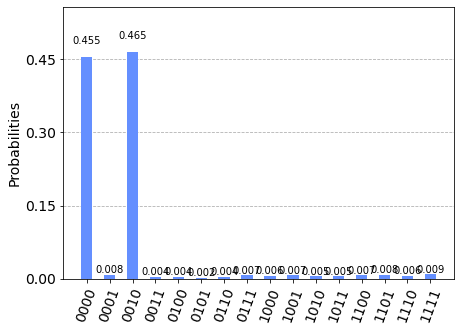

In [76]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)